### Requirements

In [ ]:
!pip install pymatgen diffusers rasterio

In [2]:
pip install --no-dependencies accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 3.4 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!nvidia-smi

Sat Mar 23 15:44:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os
import sys
sys.path.append("../")

import random
from typing import Tuple, List, Union
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from IPython.display import clear_output
from pymatgen.core import Structure

from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, random_split
from transformers import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler
from sklearn.model_selection import train_test_split

In [4]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    # Data
    image_size = 32

    # Model
    model_channels: int = 64

    # Noise Scheduler
    num_train_timesteps = 1_000
    num_inference_steps = 100
    beta_start = 0.0001
    beta_end = 0.02
    beta_schedule = "squaredcos_cap_v2"

    # Training
    batch_size = 4
    epochs = 400
    learning_rate = 1e-4
    lr_warmup_steps = 500

    # Accelerator
    gradient_accumulation_steps = 16
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision

    device = "cuda"
    random_state = 42


config = TrainingConfig()

In [5]:
def seed_everything(seed: int,
                    use_deterministic_algos: bool = False) -> None:

    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(use_deterministic_algos)
    random.seed(seed)


seed_everything(config.random_state)

In [6]:
PATH = "/content/drive/MyDrive/3d-materials-diffusion"
DATA = PATH + "/snemi/image/"
TRAIN = DATA + "train-input.tif"

# Data

In [7]:
import tifffile
from torchvision import transforms


class MaterialsDataset(Dataset):
    def __init__(self, path_to_3d_material: str = "", transforms = None, chunk_size: int = 100):
        super().__init__()

        self.path_to_3d_material = path_to_3d_material
        self.transforms = transforms
        self.chunk_size = chunk_size
        self.material = torch.from_numpy(tifffile.imread(self.path_to_3d_material))
        self.material = self._truncate(self.material)
        self.chunks = self._get_chunks(self.material, self.chunk_size)

    @staticmethod
    def _get_chunks(material, chunk_size):
        chunks = []

        d, h, w = material.shape

        for i in range(d // chunk_size):
            for j in range(h // chunk_size):
                for k in range(h // chunk_size):
                    chunks.append(
                        material[
                            i * chunk_size:(i + 1) * chunk_size,
                            j * chunk_size:(j + 1) * chunk_size,
                            k * chunk_size:(k + 1) * chunk_size,
                        ].unsqueeze(0)
                    )

        chunks = torch.cat(chunks, dim=0)

        return chunks

    @staticmethod
    def _truncate(material, h=1000, w=1000):
        return material[:, :h, :w]

    def __getitem__(self, idx: int):
        chunk = self.chunks[idx]

        if self.transforms:
            chunk = self.transforms(chunk)

        return chunk.unsqueeze(dim=0)

    def __len__(self):
        return self.chunks.shape[0]

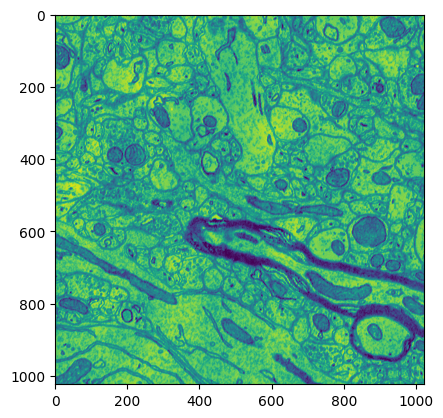

In [8]:
import matplotlib.pyplot as plt

data = torch.tensor(tifffile.imread(TRAIN))

plt.imshow(data[0])

In [9]:
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Lambda(lambda x: x / 255),
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
])


dataset = MaterialsDataset(
    TRAIN,
    chunk_size=config.image_size,
    transforms=transform,
)

train_inds,  eval_inds = train_test_split(
    [i for i in range(len(dataset))],
    test_size=0.1,
    random_state=config.random_state
    )

train_dataloader = DataLoader(
    Subset(dataset, train_inds),
    batch_size=config.batch_size,
    shuffle=True,
)

eval_dataloader = DataLoader(
    Subset(dataset, eval_inds),
    batch_size=config.batch_size,
    shuffle=False
)

In [10]:
next(iter(eval_dataloader)).shape

torch.Size([4, 1, 32, 32, 32])

### Utils for diffusion processes

In [11]:
def generate(x, model, noise_scheduler, device: str, num_inference_steps: int = 100):
    noise_scheduler.set_timesteps(num_inference_steps=num_inference_steps)
    bs = x.shape[0]
    for i, t in enumerate(noise_scheduler.timesteps):
        model_input = noise_scheduler.scale_model_input(x, t)

        t_batch = torch.full(
            size=(bs,),
            fill_value=t.item(),
            dtype=torch.long
        ).cuda()

        with torch.no_grad():
            noise_pred = model(
                model_input,
                t_batch
            )

        x = noise_scheduler.step(noise_pred, t, x).prev_sample

    return x

### Training Loop

In [12]:
def train(
    model: torch.nn.Module,
    optimizer,
    scheduler,
    accelerator,
    noise_scheduler,
    loss,
    epochs: int,
    train_dataloader: torch.utils.data.DataLoader,
    eval_dataloader: torch.utils.data.DataLoader,
    device: str,
):
    pbar = range(epochs)
    for epoch in pbar:
        train_losses = []
        eval_losses = []

        #-------------------------------------------------------------#
        # Train epoch
        model.train()
        train_losses_per_epoch = []
        for batch in tqdm(train_dataloader):
            x_1 = batch.to(device)

            bs = x_1.shape[0]
            noise = torch.rand(x_1.shape).to(x_1.device)
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (bs,), device=x_1.device
            ).long()

            noisy_x_1 = noise_scheduler.add_noise(x_1, noise, timesteps)

            with accelerator.accumulate(model):
                output = model(
                    noisy_x_1,
                    timesteps,
                )

                train_loss = loss(noise, output)
                accelerator.backward(train_loss)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            train_losses.append(train_loss.item() / bs)

        train_dict = {
                        "epoch": epoch + 1,
                        "train_manhattan_loss": np.mean(train_losses),
                     }

        #-------------------------------------------------------------#
        # Eval epoch
        model.eval()
        eval_losses_per_epoch = []
        for batch in tqdm(eval_dataloader):
            x_1 = batch.to(device)

            bs = x_1.shape[0]
            noise = torch.rand(x_1.shape).to(x_1.device)
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (bs,), device=x_1.device
            ).long()

            noisy_x_1 = noise_scheduler.add_noise(x_1, noise, timesteps)


            with torch.no_grad():
                output = model(
                    noisy_x_1,
                    timesteps,
                    return_dict=False
                )[0]

                eval_loss = loss(noise, output)

            eval_losses.append(eval_loss.item() / bs)

        eval_dict = {
                        "epoch": epoch + 1,
                        "eval_manhattan_loss": np.mean(train_losses),
                     }

        print(train_dict, eval_dict)

In [13]:
def weights_init_xavier(m):
    '''
    Xavier uniform
    '''
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

In [14]:
# !git clone https://github.com/openai/improved-diffusion.git
# !python3 ./improved-diffusion/setup.py
sys.path.append("./improved-diffusion/improved_diffusion")
sys.path.append("./improved-diffusion/")

In [15]:
from improved_diffusion.unet import UNetModel

model = UNetModel(
    in_channels=1, # should be equal to num_features (input features)
    dims=3, #this states, that we are using 1D U-Net
    model_channels=config.model_channels, # inner model features
    out_channels=1, # should be equal to num_features (input features)
    num_res_blocks=3, # idk
    attention_resolutions=(2, 4, 8) # idk
)

model.apply(weights_init_xavier)

model.to(config.device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

total_steps = int(len(train_dataloader) * config.epochs)
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                    num_warmup_steps = config.lr_warmup_steps, # Default value in run_glue.py
                                    num_training_steps = total_steps)

ddpm_scheduler = DDPMScheduler(
    num_train_timesteps=config.num_train_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule,

)
ddpm_scheduler.set_timesteps(
    num_inference_steps=config.num_inference_steps
)

ddpm_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.02,
  "beta_schedule": "squaredcos_cap_v2",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [16]:
from accelerate import Accelerator

accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
)

train_dataloader, eval_dataloader, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

In [17]:
train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    accelerator=accelerator,
    noise_scheduler=ddpm_scheduler,
    loss=F.mse_loss,
    epochs=config.epochs,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    device=config.device,
)

  0%|          | 0/649 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 863.06 MiB is free. Process 128096 has 13.90 GiB memory in use. Of the allocated memory 13.61 GiB is allocated by PyTorch, and 163.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)